<a href="https://colab.research.google.com/github/dev-SR/Deep-Learning/blob/main/02-pytorch-workflow-classification/torch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Pytorch multi-class classification workflow


In [3]:
"""
cd .\02-pytorch-workflow-classification\
jupyter nbconvert --to markdown torch_workflow.ipynb --output README.md
"""
from global_helpers import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("..")  # Add the parent directory to the path

## Simplifying implementations of common architectures via the torch.nn module


You have already seen some examples of building a feedforward NN model (for instance, a multilayer
perceptron) and defining a sequence of layers using the `nn.Module` class. Before we take a deeper dive
into `nn.Module`, let’s briefly look at another approach for conjuring those layers via `nn.Sequential`.


### Implementing models based on `nn.Sequential`


With `nn.Sequential` the layers stored inside the model are connected in a cascaded way.


In [142]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.Sigmoid(),
    nn.Linear(10, 6),
    nn.Sigmoid(),
    nn.Linear(6, 2),
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=6, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=6, out_features=2, bias=True)
)

(1000, 2) (1000,)


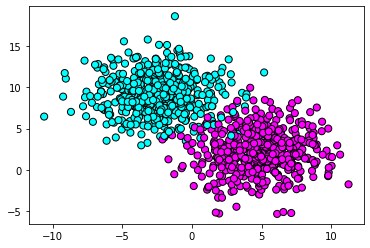

In [143]:
X_train, X_test, y_train, y_test = generate_blob_cluster(split_train_test=True)
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train).float(),
    torch.tensor(X_test).float(),
    torch.tensor(y_train).float(),
    torch.tensor(y_test).float(),
)
n_train = len(X_train)

In [144]:
train_ds = TensorDataset(X_train, y_train)
batch_size = 20
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [20]:
def train(model, num_epochs, train_dl, x_valid, y_valid, log_epochs=10):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch.long())
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            is_correct = (torch.argmax(pred, axis=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train / batch_size
        accuracy_hist_train[epoch] /= n_train / batch_size

        pred = model(x_valid)
        loss = loss_fn(pred, y_valid.long())
        loss_hist_valid[epoch] = loss.item()
        is_correct = (torch.argmax(pred, axis=1) == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
        # Logging
        if epoch % log_epochs == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")
    return {
        "loss_train": loss_hist_train,
        "loss_valid": loss_hist_valid,
        "accuracy_train": accuracy_hist_train,
        "accuracy_valid": accuracy_hist_valid,
    }

In [145]:
torch.manual_seed(1)
num_epochs = 200
log_epochs = 39
history = train(model, num_epochs, train_dl, X_test,
                y_test, log_epochs=log_epochs)

Epoch [1/200], Loss: 0.6650936603546143
Epoch [40/200], Loss: 0.3103216886520386
Epoch [79/200], Loss: 0.12023929506540298
Epoch [118/200], Loss: 0.08938241004943848
Epoch [157/200], Loss: 0.07876066118478775
Epoch [196/200], Loss: 0.07173140347003937


Text(0.5, 0, 'Epochs')

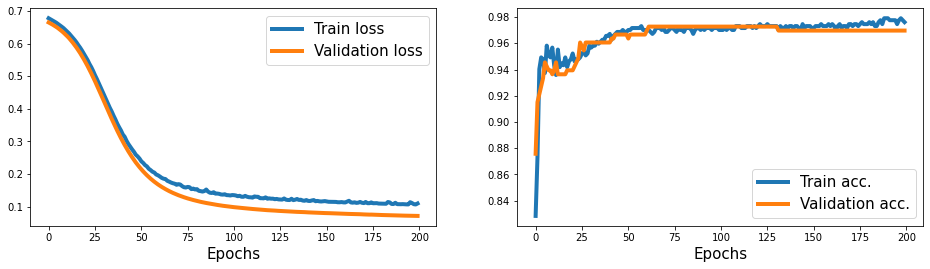

In [146]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history["loss_train"], lw=4)
plt.plot(history["loss_valid"], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history["accuracy_train"], lw=4)
plt.plot(history["accuracy_valid"], lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)

# plt.savefig('figures/13_03.png', dpi=300)

## Making model building more flexible with `nn.Module`


In the previous example, we used the PyTorch Sequential class to create a fully connected NN with
multiple layers. This is a very common and convenient way of building models. However, it unfortunately
doesn’t allow us to create more complex models that have multiple input, output, or intermediate
branches. That’s where `nn.Module` comes in handy.


The alternative way to build complex models is by subclassing nn.Module. In this approach, we create a
new class derived from nn.Module and define the method, `__init__()`, as a constructor. The `forward()`
method is used to specify the forward pass. In the constructor function, `__init__()`, we define the
layers as attributes of the class so that they can be accessed via the self reference attribute. Then, in
the `forward()` method, we specify how these layers are to be used in the forward pass of the NN. The
code for defining a new class that implements the previous model is as follows:


In [6]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 10)
        a1 = nn.Sigmoid()
        l2 = nn.Linear(10, 6)
        a2 = nn.Sigmoid()
        l3 = nn.Linear(6, 2)
        l = [l1, a1, l2, a2, l3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)
        return torch.argmax(pred, axis=1)

Notice that we put all layers in the nn.ModuleList object, which is just a list object composed of
nn.Module items. This makes the code more readable and easier to follow:


In [148]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=6, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=6, out_features=2, bias=True)
  )
)

**Next, besides the train history, we will use the `mlxtend` library to visualize the validation data and
the decision boundary. To compute the decision boundary of our model, we also need to add a `predict()` method in the `MyModule` class.**


In [149]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, X_test, y_test)

Epoch [1/200], Loss: 0.7060620784759521
Epoch [40/200], Loss: 0.4935990869998932
Epoch [79/200], Loss: 0.16367541253566742
Epoch [118/200], Loss: 0.09916793555021286
Epoch [157/200], Loss: 0.08117182552814484
Epoch [196/200], Loss: 0.0719602182507515


In [ ]:
from mlxtend.plotting import plot_decision_regions

<AxesSubplot:>

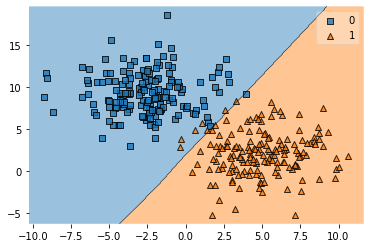

In [150]:
plot_decision_regions(
    X=X_test.numpy(), y=y_test.numpy().astype(np.int64), clf=model)

### example 2


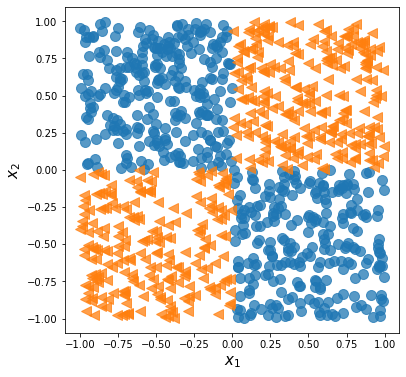

In [7]:
X_train, X_test, y_train, y_test = generate_xor_data(split_train_test=True)
X_train, X_test, y_train, y_test = (
    torch.tensor(X_train).float(),
    torch.tensor(X_test).float(),
    torch.tensor(y_train).float(),
    torch.tensor(y_test).float(),
)
n_train = len(X_train)
train_ds = TensorDataset(X_train, y_train)
batch_size = 20
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [13]:
model = MyModule()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)
# torch.manual_seed(1)
history = train(model, 100, train_dl, X_test, y_test)

Epoch [1/100], Loss: 0.6937592625617981
Epoch [11/100], Loss: 0.30175235867500305
Epoch [21/100], Loss: 0.08801449835300446
Epoch [31/100], Loss: 0.05076465755701065
Epoch [41/100], Loss: 0.04663023352622986
Epoch [51/100], Loss: 0.03594113513827324
Epoch [61/100], Loss: 0.0778207778930664
Epoch [71/100], Loss: 0.03195153549313545
Epoch [81/100], Loss: 0.035697661340236664
Epoch [91/100], Loss: 0.032447706907987595


<AxesSubplot:>

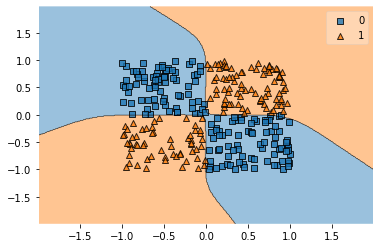

In [15]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(
    X=X_test.numpy(), y=y_test.numpy().astype(np.int64), clf=model)

## Writing custom layers in PyTorch


Creating custom layers in PyTorch involves defining a class inherited from `nn.Module`. This allows us to craft our own layer functionalities. Say, we want a unique noisy linear layer that computes $w \cdot (x + \epsilon) + b$, where $\epsilon$ signifies a random variable. To do this, we create a class, typically specifying the constructor `__init__()` and the `forward()` method. The constructor sets up the necessary tensors and variables for the layer, initializing them based on given input size or postponing initialization if the input shape isn't known upfront. As an example, let's craft a layer named `NoisyLinear` to carry out the computation mentioned earlier.


In [16]:
class NoisyLinear(nn.Module):
    def __init__(self, input_features, output_features, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(output_features, input_features)
        # nn.Parameter is a Tensor that's a module parameter.
        self.w = nn.Parameter(w)
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_features).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w.t()), self.b)

    def __repr__(self):
        return (
            "NoisyLinear(in_features="
            + str(self.w.shape[1])
            + ", out_features="
            + str(self.w.shape[0])
            + ", bias="
            + str(self.b is not None)
            + ")"
        )

In [17]:
torch.manual_seed(1)

noisy_layer = NoisyLinear(input_features=2, output_features=3)

x = torch.zeros((1, 2))
print(noisy_layer(x, training=True))

print(noisy_layer(x, training=True))

print(noisy_layer(x, training=False))

tensor([[-0.0235,  0.0468,  0.0170]], grad_fn=<AddBackward0>)
tensor([[ 0.0144,  0.0180, -0.0422]], grad_fn=<AddBackward0>)
tensor([[0., 0., 0.]], grad_fn=<AddBackward0>)


Now, let’s create a new model similar to the previous one for solving the XOR classification task.
As before, we will use the nn.Module class for model building, but this time, we will use our
`NoisyLinear` layer as the first hidden layer of the multilayer perceptron. The code is as follows:


In [26]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 10, 0.07)
        self.a1 = nn.Sigmoid()
        self.l2 = nn.Linear(10, 6)
        self.a2 = nn.Sigmoid()
        self.l3 = nn.Linear(6, 2)

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)
        return torch.argmax(pred, axis=1)


torch.manual_seed(1)
model = MyNoisyModule()
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)
model

MyNoisyModule(
  (l1): NoisyLinear(in_features=2, out_features=10, bias=True)
  (a1): Sigmoid()
  (l2): Linear(in_features=10, out_features=6, bias=True)
  (a2): Sigmoid()
  (l3): Linear(in_features=6, out_features=2, bias=True)
)

In [27]:
torch.manual_seed(1)
num_epochs = 200
log_epochs = 39


def train(model, num_epochs, train_dl, x_valid, y_valid, log_epochs=10):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            ########! setting training=True to add noise ########
            pred = model(x_batch, training=True)
            loss = loss_fn(pred, y_batch.long())
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            is_correct = (torch.argmax(pred, axis=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train / batch_size
        accuracy_hist_train[epoch] /= n_train / batch_size

        pred = model(x_valid, training=False)
        loss = loss_fn(pred, y_valid.long())
        loss_hist_valid[epoch] = loss.item()
        is_correct = (torch.argmax(pred, axis=1) == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
        # Logging
        if epoch % log_epochs == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")
    return {
        "loss_train": loss_hist_train,
        "loss_valid": loss_hist_valid,
        "accuracy_train": accuracy_hist_train,
        "accuracy_valid": accuracy_hist_valid,
    }


history = train(
    model,
    num_epochs=num_epochs,
    train_dl=train_dl,
    x_valid=X_test,
    y_valid=y_test,
    log_epochs=log_epochs,
)

Epoch [1/200], Loss: 0.6921265125274658
Epoch [40/200], Loss: 0.10089663416147232
Epoch [79/200], Loss: 0.07622559368610382
Epoch [118/200], Loss: 0.06156187877058983
Epoch [157/200], Loss: 0.05972304567694664
Epoch [196/200], Loss: 0.06177102401852608


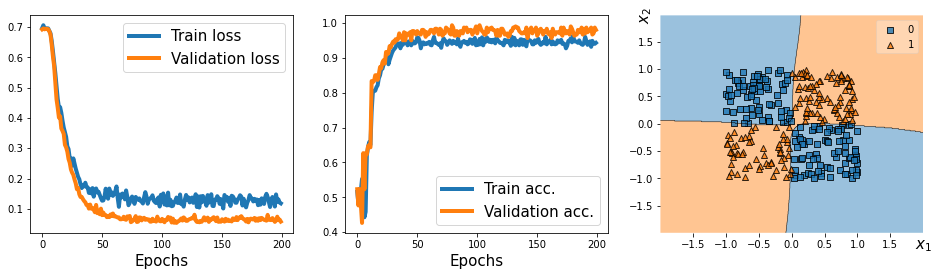

In [29]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history["loss_train"], lw=4)
plt.plot(history["loss_valid"], lw=4)
plt.legend(["Train loss", "Validation loss"], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history["accuracy_train"], lw=4)
plt.plot(history["accuracy_valid"], lw=4)
plt.legend(["Train acc.", "Validation acc."], fontsize=15)
ax.set_xlabel("Epochs", size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(
    X=X_test.numpy(), y=y_test.numpy().astype(np.int64), clf=model)
ax.set_xlabel(r"$x_1$", size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r"$x_2$", size=15)
ax.yaxis.set_label_coords(-0.025, 1)

# plt.savefig('figures/13_06.png', dpi=300)
plt.show()